In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import time

real_data = pd.read_csv("dataset_1.csv")          
synthetic_data = pd.read_csv("synthetic_data.csv")  

# Tách dữ liệu real thành train và test
X_real = real_data.drop(columns=["has_disease"])  # Đặc trưng của real data
y_real = real_data["has_disease"]  # Nhãn của real data

X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    X_real, y_real, test_size=0.2, random_state=42)

# Lấy toàn bộ dữ liệu synthetic để train
X_synthetic = synthetic_data.drop(columns=["has_disease"])  # Đặc trưng của synthetic data
y_synthetic = synthetic_data["has_disease"]  # Nhãn của synthetic data

# Kết hợp real (train) và synthetic để tạo tập huấn luyện
X_train_combined = pd.concat([X_train_real, X_synthetic], ignore_index=True)
y_train_combined = pd.concat([y_train_real, y_synthetic], ignore_index=True)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_real)  # Chỉ dùng real data để test

### Chạy với mô hình cơ bản

In [45]:
# Khởi tạo các mô hình cơ bản
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs', C=1.0),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, eval_metric='mlogloss')
}

# Container để lưu kết quả
results = []

# Huấn luyện và đánh giá các mô hình
for model_name, model in models.items():
    start_time = time.time()

    # Huấn luyện mô hình trên dữ liệu kết hợp
    model.fit(X_train_scaled, y_train_combined)

    # Dự đoán trên dữ liệu real (test)
    predictions = model.predict(X_test_scaled)

    # Tính toán các chỉ số
    accuracy = accuracy_score(y_test_real, predictions)
    precision = precision_score(y_test_real, predictions)
    recall = recall_score(y_test_real, predictions)
    elapsed_time = time.time() - start_time

    # Lưu kết quả cho mỗi mô hình
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Time (s)": elapsed_time
    })

# Chuyển kết quả thành DataFrame và in ra
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  Precision  Recall  Time (s)
0  Logistic Regression  0.611570   0.181818   0.050  0.076260
1        Random Forest  0.685950   0.750000   0.075  0.543955
2              XGBoost  0.636364   0.416667   0.250  0.196621


C:\Users\dungp\AppData\Local\Temp\ipykernel_11652\331332640.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, ax=axes[0], palette="Blues_d")
C:\Users\dungp\AppData\Local\Temp\ipykernel_11652\331332640.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Precision', data=results_df, ax=axes[1], palette="Blues_d")
C:\Users\dungp\AppData\Local\Temp\ipykernel_11652\331332640.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Recall', data=results_df, ax=axes[2], palette="

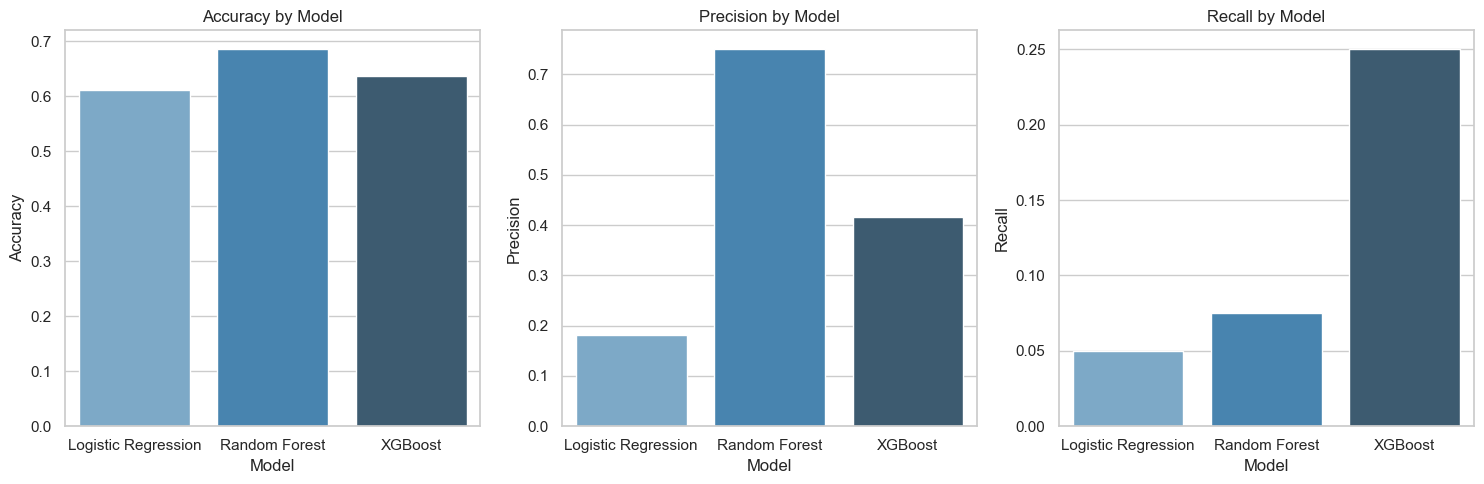

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for the plots
sns.set(style="whitegrid")

# Tạo biểu đồ cho Accuracy, Precision, Recall
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Chuyển lưới thành 1 hàng, 3 cột

# Biểu đồ Accuracy
sns.barplot(x='Model', y='Accuracy', data=results_df, ax=axes[0], palette="Blues_d")
axes[0].set_title('Accuracy by Model')

# Biểu đồ Precision
sns.barplot(x='Model', y='Precision', data=results_df, ax=axes[1], palette="Blues_d")
axes[1].set_title('Precision by Model')

# Biểu đồ Recall
sns.barplot(x='Model', y='Recall', data=results_df, ax=axes[2], palette="Blues_d")
axes[2].set_title('Recall by Model')

# Tinh chỉnh bố cục
plt.tight_layout()
plt.show()

### Chạy với CL

In [47]:
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score
import time

# Cài đặt Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size=1000):
        self.max_size = max_size
        self.buffer = []

    def store(self, data, label, model=None):
        if model is not None:
            # Ưu tiên lưu các mẫu khó phân loại
            pred = model.predict([data])
            if pred != label:  # Chỉ lưu các mẫu phân loại sai
                self._add_to_buffer(data, label)
        else:
            self._add_to_buffer(data, label)

    def _add_to_buffer(self, data, label):
        if len(self.buffer) >= self.max_size:
            self.buffer.pop(0)
        self.buffer.append((data, label))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

def compute_fisher_information(model, X_batch, y_batch):
    model.fit(X_batch, y_batch)  # Huấn luyện mô hình trên batch
    grad = np.array(model.coef_)  # Lấy gradient của trọng số
    fisher_information = np.abs(grad) ** 2  # Fisher Information Matrix ổn định hơn
    return fisher_information

def ewc_loss(model, fisher_information, previous_params, lambda_ewc=1.0):  # Tăng lambda
    current_params = np.array(model.coef_)
    return lambda_ewc * np.sum(fisher_information * (current_params - previous_params) ** 2)


# Định nghĩa các mô hình
logreg_model = LogisticRegression(solver='saga', max_iter=500, class_weight='balanced')  # Tối ưu Logistic Regression
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')  # Tối ưu Random Forest
xgb_model = xgb.XGBClassifier(eval_metric='logloss', max_depth=6, n_estimators=100, learning_rate=0.01)

# Tạo DataFrame để lưu kết quả của từng mô hình
logreg_results = {
    "Batch": [], "Accuracy": [], "Precision": [], "Recall": [], "Forgetting Rate": [], "Time (s)": []
}
rf_results = {
    "Batch": [], "Accuracy": [], "Precision": [], "Recall": [], "Forgetting Rate": [], "Time (s)": []
}
xgb_results = {
    "Batch": [], "Accuracy": [], "Precision": [], "Recall": [], "Forgetting Rate": [], "Time (s)": []
}

# Training với Replay Buffer và EWC
batch_size = 64
num_batches = int(np.ceil(len(X_train_scaled) / batch_size))
replay_buffer = ReplayBuffer(max_size=500)

# Biến tổng thời gian cho từng mô hình
total_time_logreg = 0
total_time_rf = 0
total_time_xgb = 0

# Khởi tạo Logistic Regression model lần đầu tiên
logreg_model.fit(X_train_scaled[:batch_size], y_train_combined[:batch_size])  # Huấn luyện lần đầu tiên trên một batch nhỏ

# Lưu trọng số ban đầu sau khi huấn luyện lần đầu
previous_params_logreg = np.array(logreg_model.coef_)

for batch in range(num_batches):
    # Lấy batch dữ liệu từ Replay Buffer hoặc huấn luyện mới
    X_batch = X_train_scaled[batch * batch_size:(batch + 1) * batch_size]
    y_batch = y_train_combined[batch * batch_size:(batch + 1) * batch_size]

    # Training và đánh giá Logistic Regression với EWC
    start_time = time.time()
    logreg_model.fit(X_batch, y_batch)
    
    fisher_info_logreg = compute_fisher_information(logreg_model, X_batch, y_batch)
    ewc_loss_logreg = ewc_loss(logreg_model, fisher_info_logreg, previous_params_logreg)
    logreg_model.coef_ -= ewc_loss_logreg  # Cập nhật trọng số với EWC loss

    y_pred_logreg = logreg_model.predict(X_test_scaled)
    end_time = time.time()
    batch_time_logreg = end_time - start_time
    total_time_logreg += batch_time_logreg

    accuracy_logreg = accuracy_score(y_test_real, y_pred_logreg)
    precision_logreg = precision_score(y_test_real, y_pred_logreg)
    recall_logreg = recall_score(y_test_real, y_pred_logreg)
    if batch == 0:
        prev_accuracy_logreg = accuracy_logreg
    forgetting_rate_logreg = prev_accuracy_logreg - accuracy_logreg
    prev_accuracy_logreg = accuracy_logreg

    logreg_results["Batch"].append(batch + 1)
    logreg_results["Accuracy"].append(accuracy_logreg)
    logreg_results["Precision"].append(precision_logreg)
    logreg_results["Recall"].append(recall_logreg)
    logreg_results["Forgetting Rate"].append(forgetting_rate_logreg)
    logreg_results["Time (s)"].append(batch_time_logreg)
    
    # Training và đánh giá Random Forest
    start_time = time.time()
    rf_model.fit(X_batch, y_batch)
    y_pred_rf = rf_model.predict(X_test_scaled)
    end_time = time.time()
    batch_time_rf = end_time - start_time
    total_time_rf += batch_time_rf

    accuracy_rf = accuracy_score(y_test_real, y_pred_rf)
    precision_rf = precision_score(y_test_real, y_pred_rf)
    recall_rf = recall_score(y_test_real, y_pred_rf)
    if batch == 0:
        prev_accuracy_rf = accuracy_rf
    forgetting_rate_rf = prev_accuracy_rf - accuracy_rf
    prev_accuracy_rf = accuracy_rf

    rf_results["Batch"].append(batch + 1)
    rf_results["Accuracy"].append(accuracy_rf)
    rf_results["Precision"].append(precision_rf)
    rf_results["Recall"].append(recall_rf)
    rf_results["Forgetting Rate"].append(forgetting_rate_rf)
    rf_results["Time (s)"].append(batch_time_rf)

    # Training và đánh giá XGBoost
    start_time = time.time()
    xgb_model.fit(X_batch, y_batch)
    y_pred_xgb = xgb_model.predict(X_test_scaled)
    end_time = time.time()
    batch_time_xgb = end_time - start_time
    total_time_xgb += batch_time_xgb

    accuracy_xgb = accuracy_score(y_test_real, y_pred_xgb)
    precision_xgb = precision_score(y_test_real, y_pred_xgb)
    recall_xgb = recall_score(y_test_real, y_pred_xgb)
    if batch == 0:
        prev_accuracy_xgb = accuracy_xgb
    forgetting_rate_xgb = prev_accuracy_xgb - accuracy_xgb
    prev_accuracy_xgb = accuracy_xgb

    xgb_results["Batch"].append(batch + 1)
    xgb_results["Accuracy"].append(accuracy_xgb)
    xgb_results["Precision"].append(precision_xgb)
    xgb_results["Recall"].append(recall_xgb)
    xgb_results["Forgetting Rate"].append(forgetting_rate_xgb)
    xgb_results["Time (s)"].append(batch_time_xgb)

# Chuyển kết quả thành DataFrame cho từng mô hình
logreg_df = pd.DataFrame(logreg_results)
rf_df = pd.DataFrame(rf_results)
xgb_df = pd.DataFrame(xgb_results)

# Tính giá trị trung bình cho Logistic Regression
avg_accuracy_logreg = logreg_df["Accuracy"].mean()
avg_precision_logreg = logreg_df["Precision"].mean()
avg_recall_logreg = logreg_df["Recall"].mean()

# Tính giá trị trung bình cho Random Forest
avg_accuracy_rf = rf_df["Accuracy"].mean()
avg_precision_rf = rf_df["Precision"].mean()
avg_recall_rf = rf_df["Recall"].mean()

# Tính giá trị trung bình cho XGBoost
avg_accuracy_xgb = xgb_df["Accuracy"].mean()
avg_precision_xgb = xgb_df["Precision"].mean()
avg_recall_xgb = xgb_df["Recall"].mean()

# Hiển thị kết quả cho từng mô hình và thời gian tổng
print("Logistic Regression Results:")
print(logreg_df)
print(f"Total Time (Logistic Regression): {total_time_logreg:.2f} seconds")
print(f"Logistic Regression - Avg Accuracy: {avg_accuracy_logreg:.4f}, Avg Precision: {avg_precision_logreg:.4f}, Avg Recall: {avg_recall_logreg:.4f}\n")

print("Random Forest Results:")
print(rf_df)
print(f"Total Time (Random Forest): {total_time_rf:.2f} seconds")
print(f"Random Forest - Avg Accuracy: {avg_accuracy_rf:.4f}, Avg Precision: {avg_precision_rf:.4f}, Avg Recall: {avg_recall_rf:.4f}\n")

print("XGBoost Results:")
print(xgb_df)
print(f"Total Time (XGBoost): {total_time_xgb:.2f} seconds")
print(f"XGBoost - Avg Accuracy: {avg_accuracy_xgb:.4f}, Avg Precision: {avg_precision_xgb:.4f}, Avg Recall: {avg_recall_xgb:.4f}")

Logistic Regression Results:
    Batch  Accuracy  Precision  Recall  Forgetting Rate  Time (s)
0       1  0.578512   0.403509   0.575         0.000000  0.010029
1       2  0.586777   0.419355   0.650        -0.008264  0.015620
2       3  0.603306   0.425926   0.575        -0.016529  0.016038
3       4  0.586777   0.403846   0.525         0.016529  0.031253
4       5  0.611570   0.438596   0.625        -0.024793  0.034309
5       6  0.586777   0.410714   0.575         0.024793  0.015624
6       7  0.570248   0.400000   0.600         0.016529  0.015625
7       8  0.570248   0.388889   0.525         0.000000  0.015643
8       9  0.586777   0.407407   0.550        -0.016529  0.015631
9      10  0.603306   0.431034   0.625        -0.016529  0.015623
10     11  0.595041   0.421053   0.600         0.008264  0.015625
11     12  0.578512   0.409836   0.625         0.016529  0.015642
12     13  0.528926   0.376812   0.650         0.049587  0.000000
Total Time (Logistic Regression): 0.22 seconds


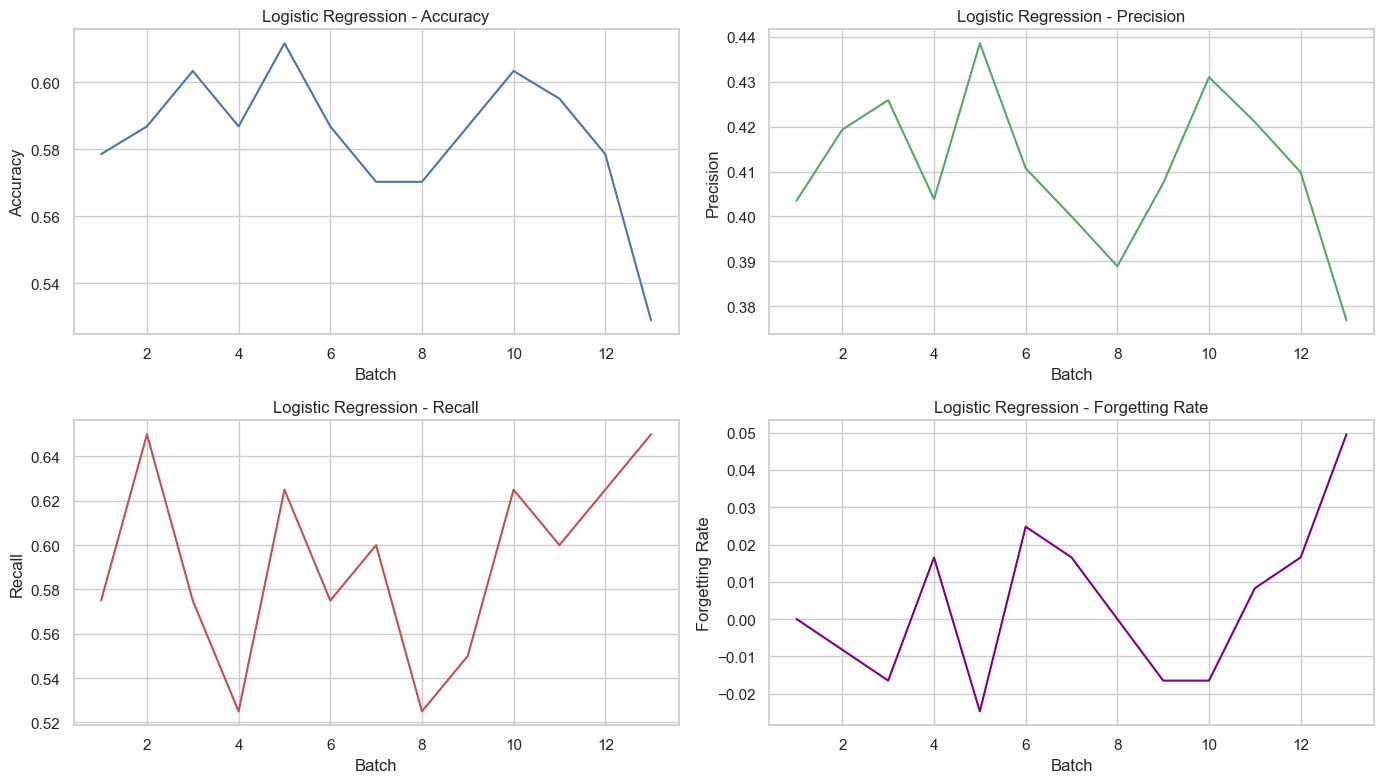

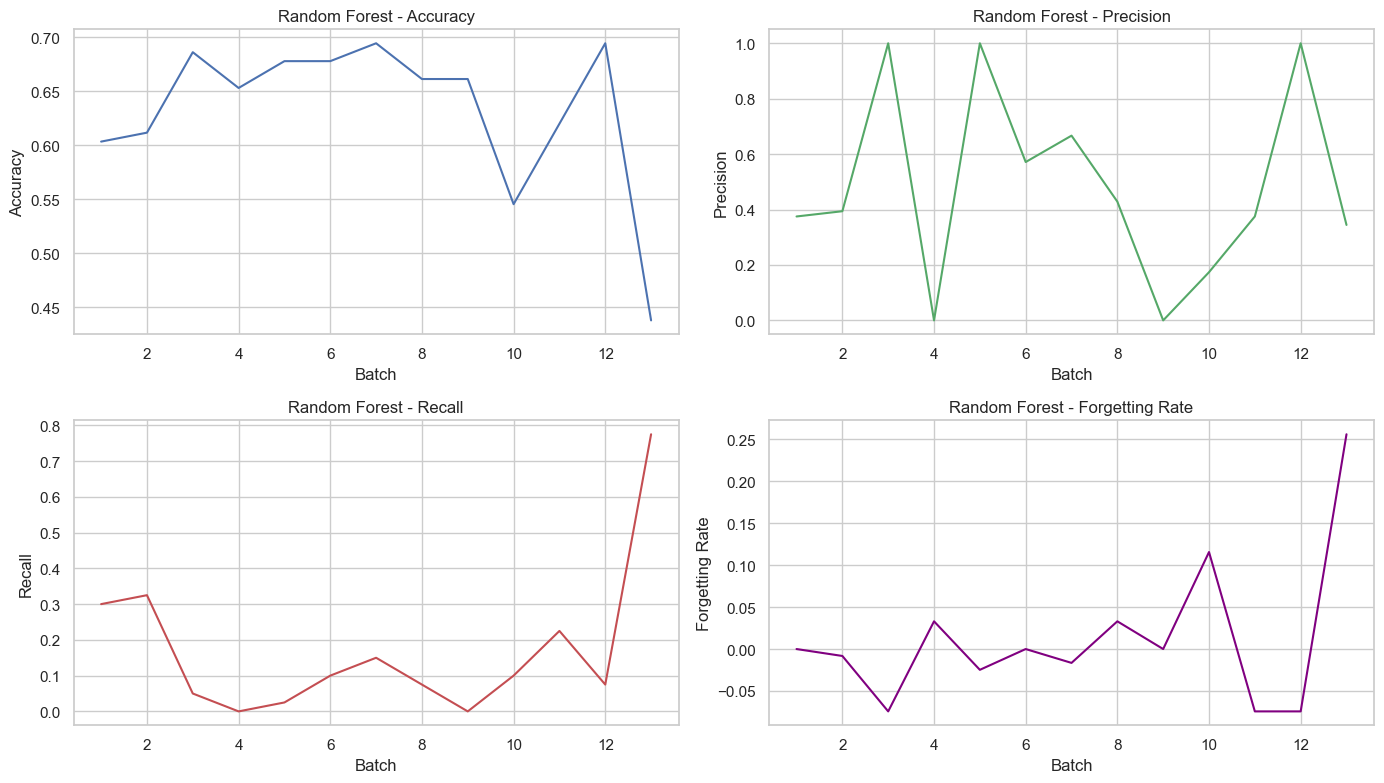

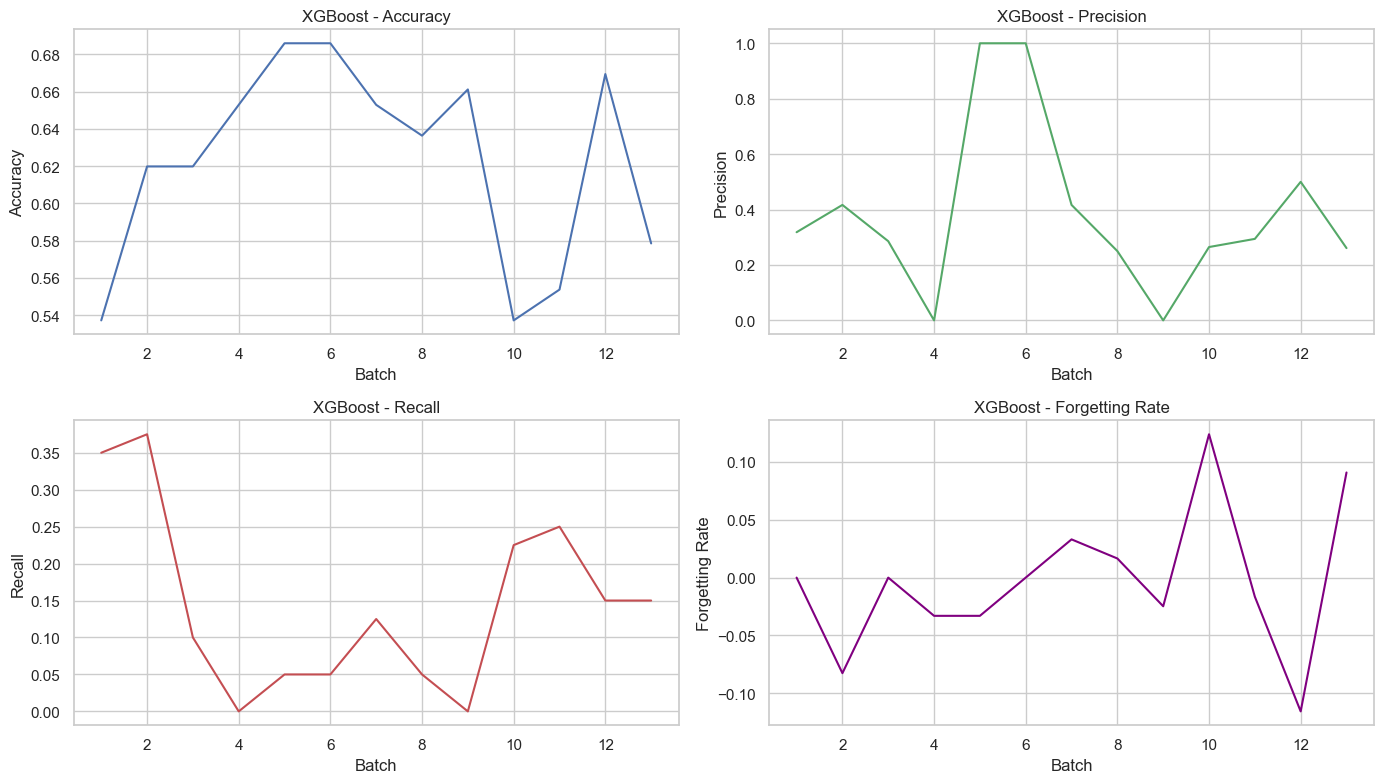

In [48]:
import matplotlib.pyplot as plt

# Vẽ biểu đồ cho Logistic Regression
plt.figure(figsize=(14, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(logreg_df['Batch'], logreg_df['Accuracy'], label='Accuracy', color='b')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Logistic Regression - Accuracy')
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(logreg_df['Batch'], logreg_df['Precision'], label='Precision', color='g')
plt.xlabel('Batch')
plt.ylabel('Precision')
plt.title('Logistic Regression - Precision')
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(logreg_df['Batch'], logreg_df['Recall'], label='Recall', color='r')
plt.xlabel('Batch')
plt.ylabel('Recall')
plt.title('Logistic Regression - Recall')
plt.grid(True)

# Forgetting Rate
plt.subplot(2, 2, 4)
plt.plot(logreg_df['Batch'], logreg_df['Forgetting Rate'], label='Forgetting Rate', color='purple')
plt.xlabel('Batch')
plt.ylabel('Forgetting Rate')
plt.title('Logistic Regression - Forgetting Rate')
plt.grid(True)

plt.tight_layout()
plt.show()

# Vẽ biểu đồ cho Random Forest
plt.figure(figsize=(14, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(rf_df['Batch'], rf_df['Accuracy'], label='Accuracy', color='b')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('Random Forest - Accuracy')
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(rf_df['Batch'], rf_df['Precision'], label='Precision', color='g')
plt.xlabel('Batch')
plt.ylabel('Precision')
plt.title('Random Forest - Precision')
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(rf_df['Batch'], rf_df['Recall'], label='Recall', color='r')
plt.xlabel('Batch')
plt.ylabel('Recall')
plt.title('Random Forest - Recall')
plt.grid(True)

# Forgetting Rate
plt.subplot(2, 2, 4)
plt.plot(rf_df['Batch'], rf_df['Forgetting Rate'], label='Forgetting Rate', color='purple')
plt.xlabel('Batch')
plt.ylabel('Forgetting Rate')
plt.title('Random Forest - Forgetting Rate')
plt.grid(True)

plt.tight_layout()
plt.show()

# Vẽ biểu đồ cho XGBoost
plt.figure(figsize=(14, 8))

# Accuracy
plt.subplot(2, 2, 1)
plt.plot(xgb_df['Batch'], xgb_df['Accuracy'], label='Accuracy', color='b')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.title('XGBoost - Accuracy')
plt.grid(True)

# Precision
plt.subplot(2, 2, 2)
plt.plot(xgb_df['Batch'], xgb_df['Precision'], label='Precision', color='g')
plt.xlabel('Batch')
plt.ylabel('Precision')
plt.title('XGBoost - Precision')
plt.grid(True)

# Recall
plt.subplot(2, 2, 3)
plt.plot(xgb_df['Batch'], xgb_df['Recall'], label='Recall', color='r')
plt.xlabel('Batch')
plt.ylabel('Recall')
plt.title('XGBoost - Recall')
plt.grid(True)

# Forgetting Rate
plt.subplot(2, 2, 4)
plt.plot(xgb_df['Batch'], xgb_df['Forgetting Rate'], label='Forgetting Rate', color='purple')
plt.xlabel('Batch')
plt.ylabel('Forgetting Rate')
plt.title('XGBoost - Forgetting Rate')
plt.grid(True)

plt.tight_layout()
plt.show()
